<a href="https://colab.research.google.com/github/tinahuang222/NucleiSegmentation/blob/master/PREPROCESSING/ColorConvolve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
%matplotlib inline

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

from PIL import Image  

import json
import pandas as pd

import csv

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

!pip3 install histomicstk

import histomicstk as htk
#specific versions required for downloaded code segments
#!pip3 install -q scipy==1.2.0
#!pip3 install -q imgaug==0.2.6


#
# Read Data from google drive
#
from google.colab import drive #for loading gdrive data
drive.mount('/content/gdrive')

### MAIN DIRECTORY NAMES
gdir =           '/content/gdrive/My Drive/'
main_directory = gdir

#
#directory of top level of user data
#
feature_folder = os.path.join(gdir,'FEATURE_EXTRACTION')
original_image_folder = os.path.join(feature_folder,'tiles_rois','original')

tiles_dir = os.path.join(gdir,feature_folder,'tiles_rois','normalized')
tile_melanomas_dir = os.path.join(gdir,feature_folder,'tile_melanomas_examples')
tile_label_dir = os.path.join(gdir,feature_folder,'tiles_rois')
mask_dir = os.path.join(gdir,'masks')



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


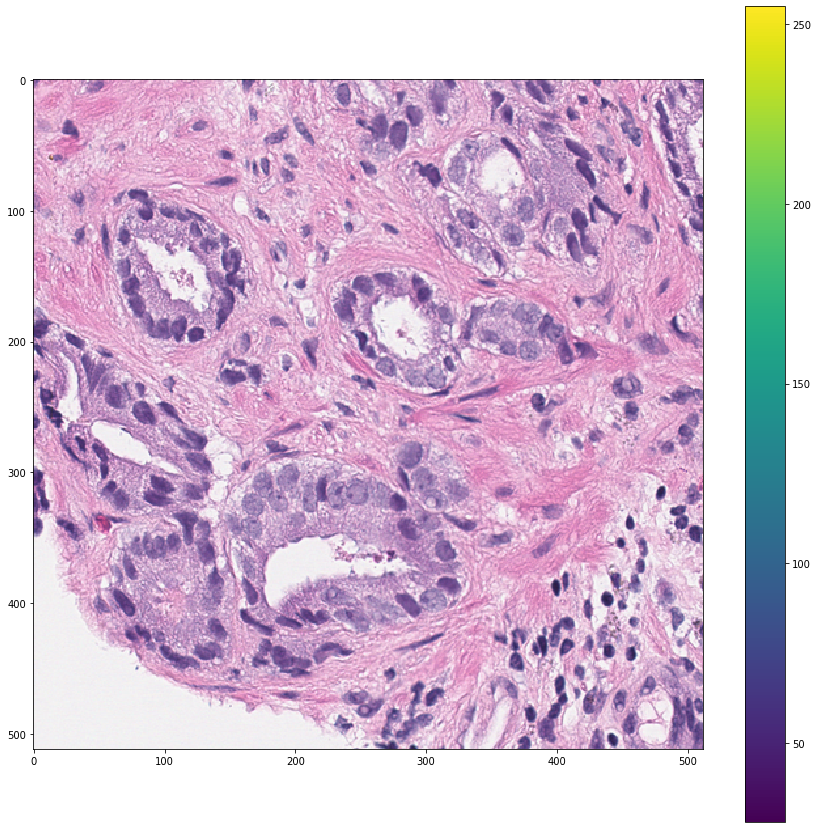

In [16]:
'''
Get image files and load them into memory
'''


#get listing of image files in directory
image_files = os.listdir(original_image_folder)

#open the images
image_data = {}
for fcounter,filename in enumerate(image_files):
    full_filename = os.path.join(original_image_folder,filename)
    #root_ext = os.path.splitext(filename)
    #tile_file = root_ext[0] + '.png'
    #    tile_roi_file = os.path.join(tiles_dir, tile_file)

    if (fcounter < 10):
        image_data[fcounter] = Image.open(full_filename)
    

#review sample image
plt.figure(figsize=(15, 15))
plt.imshow(image_data[0])
plt.colorbar()
plt.show()

In [27]:
'''
Perform histomicsTK prep
'''
# create stain to color map
stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
print('stain_color_map:', stain_color_map, sep='\n')

# specify stains of input image
stains = ['hematoxylin',  # nuclei stain
          'eosin',        # cytoplasm stain
          'null']         # set to null if input contains only two stains

# create stain matrix
W = np.array([stain_color_map[st] for st in stains]).T

imInput = np.array(image_data[0]) #convert to NP array format first
# perform standard color deconvolution
imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, W)

print('shape of imDeconvolved is ', np.shape(imDeconvolved))


stain_color_map:
{'hematoxylin': [0.65, 0.7, 0.29], 'eosin': [0.07, 0.99, 0.11], 'dab': [0.27, 0.57, 0.78], 'null': [0.0, 0.0, 0.0]}
shape of imDeconvolved is  (3,)


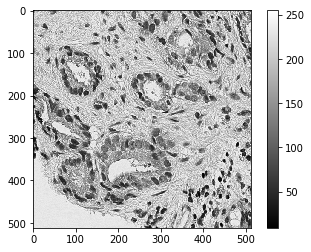

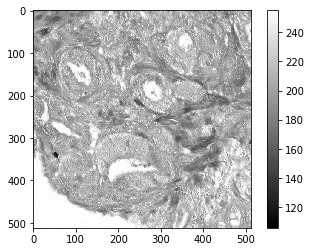

In [32]:
plt.figure()
plt.imshow(imDeconvolved.Stains[:, :, 0],cmap = 'gray')
plt.colorbar()

plt.figure()
plt.imshow(imDeconvolved.Stains[:, :, 1],cmap = 'gray')
plt.colorbar()